In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

## Plot Some Exemplary Train Data Points

In [17]:
n_train = train_dataloader.dataset.data.shape
n_train

torch.Size([60000, 28, 28])

In [18]:
s_targets = pd.Series(train_dataloader.dataset.targets.numpy())
df_targets = pd.DataFrame({"class_label":s_targets})

In [19]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

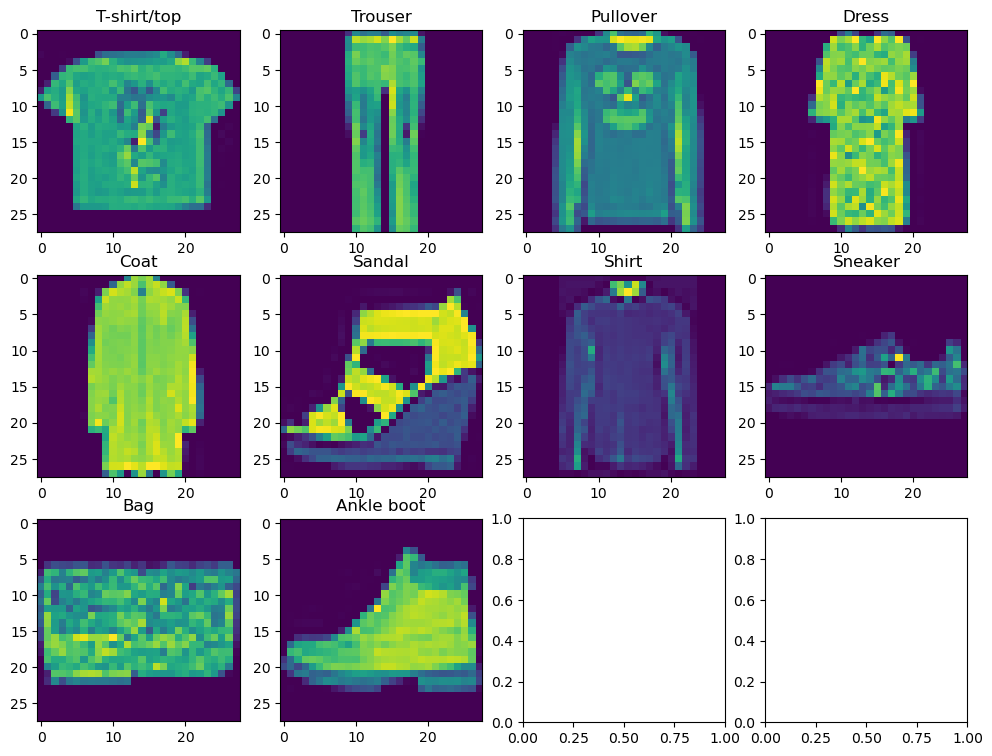

In [20]:
# select some class examples
df_targets["row_num"] = df_targets.index
df_targets["row_num_class"] = df_targets.groupby("class_label").cumcount()+1
max_label = df_targets["row_num_class"].max()
s_idxs = np.floor(np.random.uniform(0, max_label, size = len(s_targets.unique())))
df_examples = pd.DataFrame({"class":np.arange(0, len(s_targets.unique())), "idx":s_idxs})

# save selected images as examples to predict for the trained model
examples_test = list()
classes_test = list()

# plot selection
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for index, row in df_examples.iterrows():
    if index < 10:
        cl = df_targets.query(f"""class_label == {row['class']}""")
        img = cl.query(f"""row_num_class == {row['idx']}""")
        m_img = train_dataloader.dataset.data[int(img["row_num"])]
        str_title = train_dataloader.dataset.classes[index]
        r = int(np.floor(index/4))
        c = np.mod(index, 4)
        axes[r, c].imshow(m_img)
        axes[r, c].set_title(str_title)
        # and store examples in separate lists
        examples_test.append(m_img)
        classes_test.append(str_title)

In [21]:
class ReducedVGG(nn.Module):
    def __init__(self):
        super(ReducedVGG, self).__init__()
        self.flatten = nn.Flatten()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.5, inplace=False),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.5, inplace=False),
            nn.Linear(in_features=64, out_features=10, bias=True),
        )

    def forward(self, x):
        result_conv = self.features(x)
        result_conv_flat = self.flatten(result_conv)
        result_class = self.classifier(result_conv_flat)
        return result_class

model = ReducedVGG()

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
print("Nr. Parameters =", count_parameters(model))

Nr. Parameters = 725450


In [24]:
learning_rate = 1e-3
batch_size = 64
epochs = 10

In [25]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.288996  [    0/60000]
loss: 2.306900  [ 6400/60000]
loss: 2.282399  [12800/60000]
loss: 2.265102  [19200/60000]
loss: 2.276959  [25600/60000]
loss: 2.223905  [32000/60000]
loss: 2.226943  [38400/60000]
loss: 2.236316  [44800/60000]
loss: 2.196196  [51200/60000]
loss: 2.166558  [57600/60000]
Test Error: 
 Accuracy: 31.1%, Avg loss: 2.163662 

Epoch 2
-------------------------------
loss: 2.160669  [    0/60000]
loss: 2.191327  [ 6400/60000]
loss: 2.151506  [12800/60000]
loss: 2.135003  [19200/60000]
loss: 2.050994  [25600/60000]
loss: 2.120417  [32000/60000]
loss: 1.987131  [38400/60000]
loss: 1.972371  [44800/60000]
loss: 1.909079  [51200/60000]
loss: 1.874010  [57600/60000]
Test Error: 
 Accuracy: 36.6%, Avg loss: 1.900492 

Epoch 3
-------------------------------
loss: 1.930995  [    0/60000]
loss: 1.893112  [ 6400/60000]
loss: 1.798868  [12800/60000]
loss: 1.859463  [19200/60000]
loss: 1.763708  [25600/60000]
loss: 1.801465  [32000/600

KeyboardInterrupt: 

In [305]:
r_o_w = "write"
f_model = 'reduced-vgg-model.pth'
if r_o_w == "write":
    torch.save(model, f_model)
elif r_o_w == "read":
    torch.load(f_model)

In [380]:
model.eval()

ReducedVGG(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): BatchNorm2d(256, eps

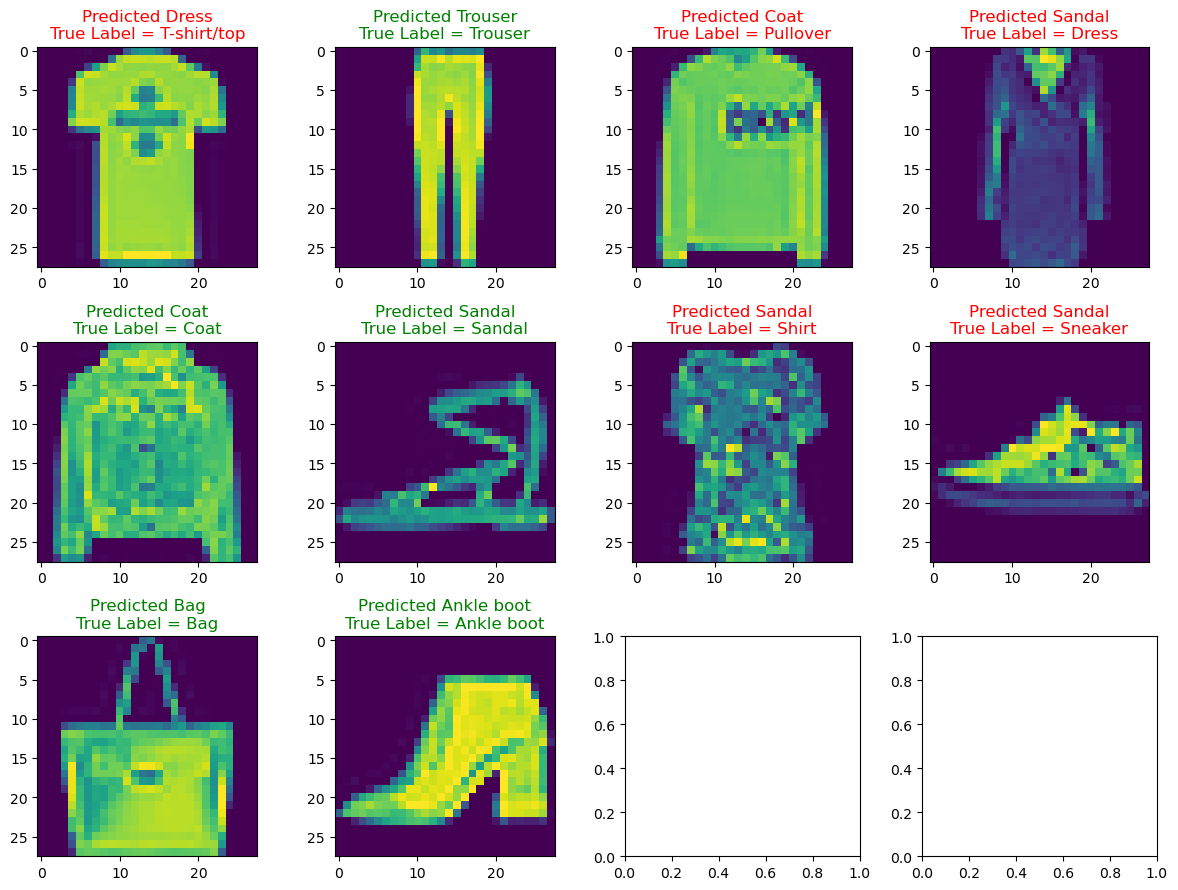

In [433]:
# select some class examples
df_targets["row_num"] = df_targets.index
df_targets["row_num_class"] = df_targets.groupby("class_label").cumcount()+1
max_label = df_targets["row_num_class"].max()
s_idxs = np.floor(np.random.uniform(0, max_label, size = len(s_targets.unique())))
df_examples = pd.DataFrame({"class":np.arange(0, len(s_targets.unique())), "idx":s_idxs})

# save selected images as examples to predict for the trained model
examples_test = list()
classes_test = list()

# plot selection
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for index, row in df_examples.iterrows():
    if index < 10:
        cl = df_targets.query(f"""class_label == {row['class']}""")
        img = cl.query(f"""row_num_class == {row['idx']}""")
        m_img = train_dataloader.dataset.data[int(img["row_num"])]
        str_title_true = train_dataloader.dataset.classes[index]
        
        # predict
        x_pred = m_img.reshape(1, 1, 28, 28).to(torch.float32)
        pred = model(x_pred).detach().numpy()
        pred_max = np.max(pred)
        pred_class = pred.reshape(10).tolist().index(pred_max)
        str_title_pred = train_dataloader.dataset.classes[pred_class]
        col_ttl = ["g" if str_title_true == str_title_pred else "r"]
        
        r = int(np.floor(index/4))
        c = np.mod(index, 4)
        axes[r, c].imshow(m_img)
        axes[r, c].set_title(f"""Predicted {str_title_pred}\nTrue Label = {str_title_true}""", c=col_ttl[0])
fig.tight_layout()